In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## import necessary library 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
import re 

## load train and test dataset

In [2]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')

## check sample of data to get some idea about data 

In [3]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5796,0f8152e6b5243cb3,"""== Upcoming N64 Virtual Console Titles ==\n\n...",0,0,0,0,0,0
25097,426d3e38cf37e9ec,Red line: I can't try to build up this article...,0,0,0,0,0,0
133721,cb67480380f18ea4,Please\nDon't you think the death penalty is f...,0,0,0,0,0,0
109895,4bc273e0d57cf51a,His views on India are well known and he was a...,0,0,0,0,0,0
136904,dc70bb8328730e0f,REDIRECT Talk:Buckskin Frank Leslie,0,0,0,0,0,0


## In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [5]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## check for any null comments

In [6]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [7]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


## All rows in the training and test data contain comments, so there's no need to clean up null fields.

In [9]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


## As mentioned earlier, majority of the comments in the training data are not labelled in one or more of these categories.

In [10]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

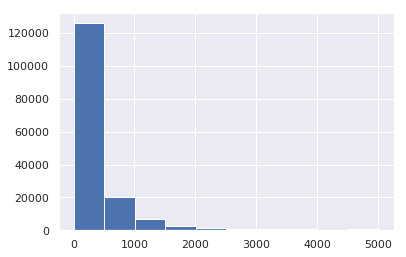

In [11]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

## Most of the text length are within 500 characters, with some up to 5,000 characters long.
## Next, let's examine the correlations among the target variables

In [13]:
data = train_df[cols_target]

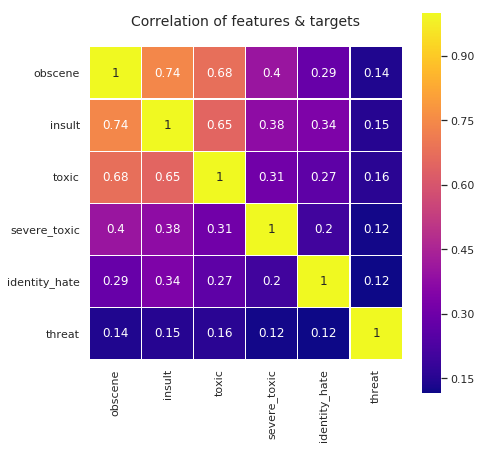

In [14]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

## Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.


In [15]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

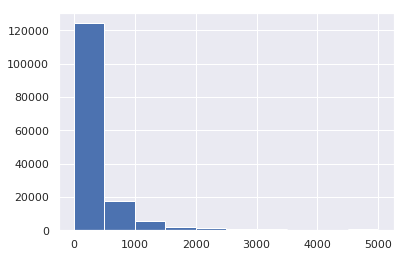

In [16]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

## Now, the shape of character length distribution looks similar between the training data and the train data. For the training data, I guess the train data were clipped to 5,000 characters to facilitate the folks who did the labelling of the comment categories.


In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's","what is ",text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
# clean the comment_text in train_df
train_df['comment_text'] = train_df['comment_text'].map(lambda x:clean_text(x))

In [19]:
# clean the comment_text in test_df
test_df['comment_text'] = test_df['comment_text'].map(lambda x:clean_text(x))

## Define X from entire train & test data for use in tokenization by Vectorizer

In [20]:
train_df = train_df.drop('char_length',axis=1)

In [21]:
X = train_df.comment_text
test_X = test_df.comment_text 

In [22]:
print(X.shape,test_X.shape)

(159571,) (153164,)


## Vectorize the data

In [23]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [24]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
logreg = LogisticRegression(C=12.0)

for label in cols_target:
    print('...Processing {}'.format(label))
    y = train_df[label]
    logreg.fit(X_dtm,y)
    y_pred_X= logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y,y_pred_X)))

...Processing obscene


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy is 0.9832363023356374
...Processing insult
Training accuracy is 0.9755469352200588
...Processing toxic
Training accuracy is 0.9639846839337975
...Processing severe_toxic
Training accuracy is 0.9920724943755445
...Processing identity_hate
Training accuracy is 0.9939713356436947
...Processing threat
Training accuracy is 0.9981199591404453
